## Lab 9: Predicting Forest Cover Type with SVMs

### Introduction
In this lab, we will explore the application of Support Vector Machines (SVMs) and Random Forests (RFs) for multi-class classification using cartographic variables. Specifically, we will predict forest cover type based on a variety of environmental features such as elevation, soil type, and land aspect.

Understanding forest cover classification is crucial for natural resource management. Land managers and conservationists rely on accurate predictions of vegetation types to make informed decisions about wildlife habitats, fire management, and sustainable forestry practices. However, direct field assessments of forest cover can be costly and time-consuming, making predictive models a valuable tool for estimating cover types in large or inaccessible regions.

Dataset info here: https://archive.ics.uci.edu/dataset/31/covertype


### Step 0: Load Libraries and Data

In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/covtype_sample.csv")

### Step 1: Data Preprocessing 

Before building our classification models, we need to prepare the dataset by separating the features target variable (`Cover_Type`) and  splitting the data into training and test sets. 

We didn't explicitly discuss it in lecture, but SVMs are sensitive to feature scale.  Use `describe()` to summarize the dataset.  Do you see anything that would require scaling of the data?  If so, apply that transformation.

In [2]:
# View data using describe
df.describe()  

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_Rawah,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2955.599500,154.450000,14.114700,268.097600,45.755300,2319.360300,212.19660,223.113500,142.243800,1960.040200,...,0.091200,0.082900,0.00250,0.00250,0.000200,0.000500,0.026800,0.024500,0.013600,2.036600
std,281.786673,111.851861,7.499705,211.899673,58.034207,1548.558651,26.98846,19.871067,37.799752,1320.535941,...,0.287908,0.275745,0.04994,0.04994,0.014141,0.022356,0.161507,0.154603,0.115829,1.383782
min,1860.000000,0.000000,0.000000,0.000000,-164.000000,0.000000,68.00000,71.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2804.750000,58.000000,9.000000,95.000000,7.000000,1091.750000,198.00000,213.000000,119.000000,1006.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2995.000000,126.000000,13.000000,218.000000,29.000000,1977.000000,218.00000,226.000000,142.000000,1699.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3159.000000,258.000000,18.000000,384.000000,68.000000,3279.000000,231.00000,237.000000,168.000000,2524.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3846.000000,359.000000,65.000000,1243.000000,427.000000,7078.000000,254.00000,254.000000,246.000000,7111.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


The `describe` method gives us the summary statistics for each column in our dataframe. From using this method, we are able to get a glimpse of each variables distributions. From looking at the information for each variable, I would say that they need to be scaled as they have different measurements. 

In [3]:
# Split the data into features and target
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=808)

In [4]:
# Scale the data
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

### Step 2: Hyperparameter Tuning for SVM
To optimize our SVM model, we need to search for the best hyperparameters that maximize classification accuracy. Since SVM performance depends heavily on `C`, `kernel`, and `gamma`, we will use `GridSearchCV()` to systematically test different combinations. Initialize a cross validation object with 5 folds using `StratifiedKFold`. Check out how `StratifiedKFold` differs from `Kfold` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). 

Then, set up a grid to test different values of: 
- `C` (regularization strength): how strictly the model fits the training data
  - Candidate parameter values: `(0.1, 1, 10, 100)`
- `kernel` (decision boundary shape): compares linear and radial basis function shapes
  - Candidate parameter values: (linear, rbf)
- `gamma` (influence of training observations): influence of individual points on decision boundary
  - Candidate parameter values: (scale, auto)

As models and datasets become more complex, consideration of computation time becomes more important.  You'll use `time.time()` to measure the time required to fit the grid object.  

**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [5]:
# Initialize CV object with 5 folds
cv = StratifiedKFold(n_splits=5)

# Set up the RBF kernel and hyperparameter tuning and fit
param_grid_svm = {
    'C': [0.1 , 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(random_state=808),
                               param_grid_svm, cv = cv, scoring='accuracy')

# Start Time for model
time_start = time.time()

# Fit the model
grid_search_svm.fit(X_train_scaled, y_train)

# End time for model 
time_end = time.time()

# Print time taken
print(f"Total time taken: {time_end - time_start} seconds")

Total time taken: 5414.9408223629 seconds


In [8]:
# Best SVM model
best_svm = grid_search_svm.best_estimator_
print(f"Best SVM model: {best_svm}")

print(f"Best SVM Model {grid_search_svm.best_params_}")

Best SVM model: SVC(C=100, gamma='auto', random_state=808)
Best SVM Model {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}


### Step 3: Build a fit a Random Forest for comparison

Let's compare our SVM to a Random Forest classifier.  Create a grid for cross-validation with three hyperparameters of your choice to tune, along with three sensible values for each one.  
**Print the best parameters from your model, as well as the time required to fit the grid object.** 

In [10]:
# Create cross validation
cv = StratifiedKFold(n_splits=5)

# Set up the Random Forest and hyperparameter tuning and fit
param_grid_rf = {
    'n_estimators': [10, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50]
}

# GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=808),
                              param_grid_rf, cv=cv, scoring='accuracy')

# Start Time for model
time_start = time.time()

# Fit the model
grid_search_rf.fit(X_train_scaled, y_train)

# End time for model
time_end = time.time()

# Print time taken
print(f"Total time taken: {time_end - time_start} seconds")

# Print best Random Forest model
print(f"Best Random Forest Moodel: {grid_search_rf.best_params_}")

c:\Users\tdude\anaconda3\envs\ml-env\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
75 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\tdude\anaconda3\envs\ml-env\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tdude\anaconda3\envs\ml-env\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\tdude\anaconda3\envs\ml-env\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  

Total time taken: 69.50661730766296 seconds
Best Random Forest Moodel: {'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 50}


### Step 4: Model Predictions and Evaluation
Now that you have trained and optimized both a SVM and RF model, you will evaluate their performances on the test set to prepare for model comparison. In this step, you will:
- Use the best models from `GridSearchCV()` to make predictions on the test set
- Generate a confusion matrix for each model to visualize classification performance


In [ ]:

# Best Random Forest model
best_rf = grid_search_rf.best_estimator_

# Predictions for Random Forest
y_pred_rf = best_rf.predict(X_test_scaled)

# Accuracy for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Print accuracy for Random Forest
print(f"Accuracy for Random Forest: {accuracy_rf}")

# Predictions for SVM
y_pred_svm = best_svm.predict(X_test_scaled)

# Accuracy for SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Print accuracy for SVM
print(f"Accuracy for SVM: {accuracy_svm}")

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)


Accuracy for Random Forest: 0.8086666666666666
Accuracy for SVM: 0.7696666666666667


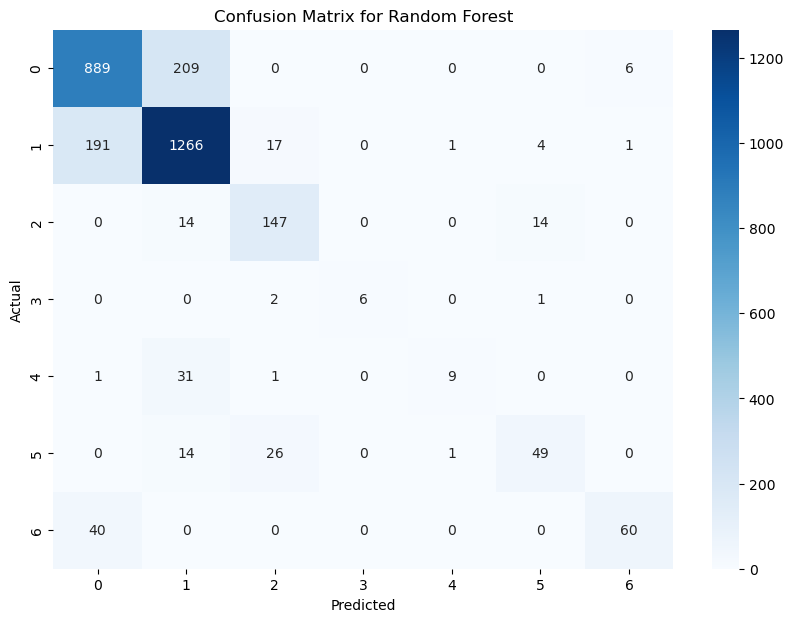

In [12]:

# Plot the confusion matrix for Random Forest
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


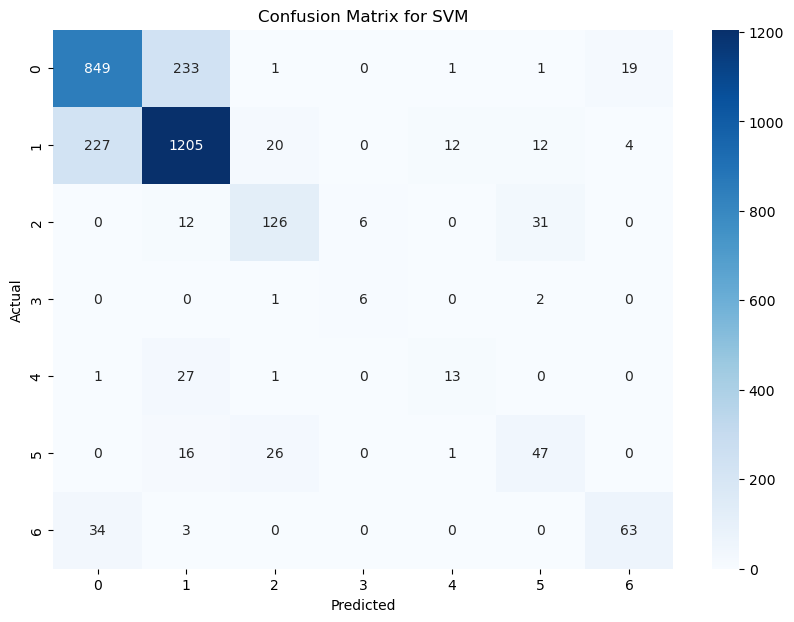

In [13]:
# Plot the confusion matrix for SVM
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

### Step 5: Gather and display additional performance metrics
Now display the accuracy score and training time required for each model to so we can compare the models.

In [14]:
# Display accuracy score and training time for both models
print(f"Accuracy for Random Forest: {accuracy_rf}")
print(f"Accuracy for SVM: {accuracy_svm}")

print(f"Training time for Random Forest: {time_end - time_start} seconds")
print(f"Training time for SVM: {time_end - time_start} seconds")



Accuracy for Random Forest: 0.8086666666666666
Accuracy for SVM: 0.7696666666666667
Training time for Random Forest: 69.50661730766296 seconds
Training time for SVM: 69.50661730766296 seconds


### Step 6: Compare the models
Now that we have trained, optimized, and evaluated both SVM and RF models, we will compare them based on overall accuracy, training time, and types of errors made.

Based on these comparisons, which model is more suitable for this task?  


*your answer here*